# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download Dataset

In [5]:
file={"username":"mojtabanafez","key":"7c0ebd541704e0cb4357c05f78ed5fa2"}
import json
with open('kaggle.json', 'w') as fp:
    json.dump(file, fp)
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

100% 1.82G/1.83G [00:15<00:00, 33.4MB/s]
100% 1.83G/1.83G [00:15<00:00, 126MB/s] 


In [7]:
!unzip -q /content/stanford-car-dataset-by-classes-folder.zip

# Create Generator

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

TRAIN_DATA_PATH = "./car_data/car_data/train"
TEST_DATA_PATH = "./car_data/car_data/test"

TRANSFORM_IMG_test =  transforms.Compose(
    [
      transforms.ToTensor(), 
      transforms.Resize(size=(224,224)),
     ])

TRANSFORM_IMG_train =  transforms.Compose(
    [
      transforms.ToTensor(), 
      transforms.RandomRotation(30),
      transforms.RandomHorizontalFlip(),
      transforms.Resize(size=(224,224)),
     ])
BATCH_SIZE=32
batch_size_1 = 10
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG_train)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG_test)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 


In [ ]:
len(train_data_loader), len(test_data_loader)


(255, 252)

In [9]:
classes = list(train_data.class_to_idx)
# classes_id = torch.Tensor(range(196))

dl=iter(train_data_loader)
x, y= next(dl)
x.shape, y.shape, torch.mean(x), torch.min(x), torch.max(x)


(torch.Size([32, 3, 224, 224]),
 torch.Size([32]),
 tensor(0.3851),
 tensor(0.),
 tensor(1.))

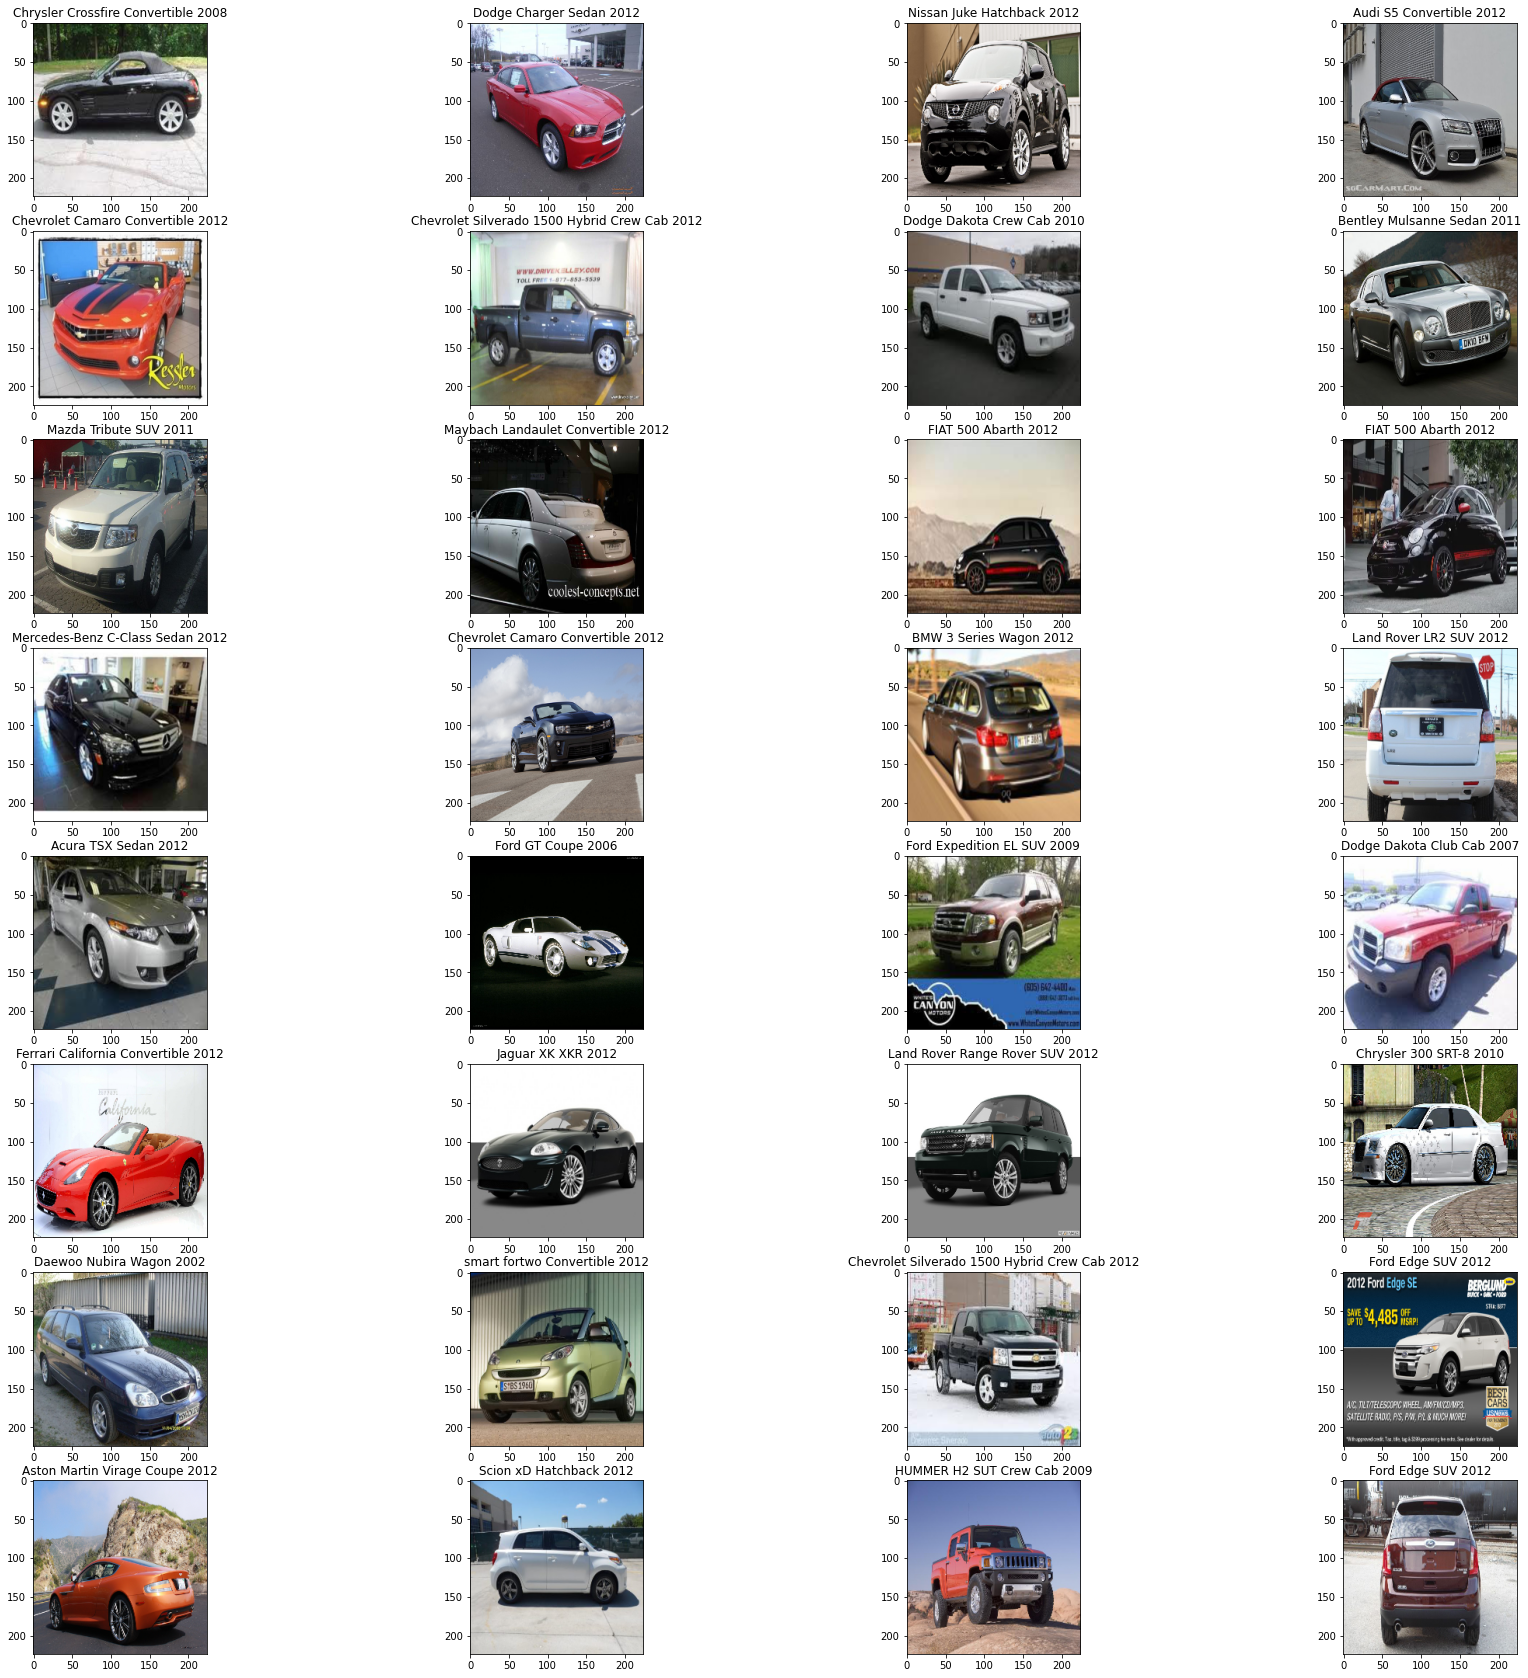

In [ ]:
import numpy as np

test_loader=iter(test_data_loader)
image, labels = test_loader.next()
image=np.array(image)
nrows=8
ncols=4
plt.figure (figsize = (30, 30))
image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 1, 2))
for i in range(image.shape[0]):
    sp = plt.subplot(nrows, ncols, i+1)
    plt.imshow(image[i])
    plt.title(classes[int(labels[i])])
plt.show()
# print(image.shape, np.mean(image), np.max(image), np.min(image))

In [10]:
dataloaders={
    'train':train_data_loader,
    'val': test_data_loader
}
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val']}

def save_checkpoint (state, filename):
    """ saving model's weights """
    print ('=> saving checkpoint')
    torch.save (state, filename)


def load_checkpoint (checkpoint, model):
    """ loading model's weights """
    print ('=> loading checkpoint')
    model.load_state_dict (checkpoint ['state_dict'])


def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')
            data_size=0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = torch.squeeze(outputs)
                    preds = (outputs > 0.5).float ()
                    loss = criterion(outputs.float(), labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                data_size+=len(outputs)

                current_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(preds, dim=-1)
                current_corrects += torch.sum(preds == labels.data)            


            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / data_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                  
        # saving models weights
        if epoch % 3 == 0:
          checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
          save_checkpoint(checkpoint, f'/content/checkpoint_{epoch}.pth')

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model
dataset_sizes

{'train': 255, 'val': 252}

In [11]:
class ResnetModel(nn.Module):
    def __init__(self, original_model, num_classes, classifier= None):
        super(ResnetModel, self).__init__()

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        if classifier == None:
          print('default classifier ...')
          self.classifier = nn.Sequential(
              nn.Linear(2048, num_classes),
          )
        else:
          print('built classifier ...')
          self.classifier = classifier

    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y

# A

In [ ]:
# Create Res-Net model with ranom weights
res_mod_rand_weights = models.resnet50(pretrained=False)
model_rand_weights = ResnetModel(res_mod_rand_weights, num_classes=len(classes))
pytorch_total_params = sum(p.numel() for p in model_rand_weights.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model_rand_weights.parameters() if p.requires_grad)
print('pytorch_total_params= ', pytorch_total_params )
print('pytorch_total_trainable_params= ', pytorch_total_trainable_params)
model_rand_weights

pytorch_total_params=  23909636
pytorch_total_trainable_params=  23909636


ResnetModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_rand_weights = model_rand_weights.to(device)
criterion = nn.CrossEntropyLoss() 

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_rand_weights.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
base_model = train_model(model_rand_weights, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)


Epoch 0/9
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 173.1978 Acc: 0.0052
Iterating through data...
val Loss: 168.6021 Acc: 0.0096
=> saving checkpoint

Epoch 1/9
----------
Iterating through data...
train Loss: 166.6883 Acc: 0.0068
Iterating through data...
val Loss: 165.8531 Acc: 0.0087
=> saving checkpoint

Epoch 2/9
----------
Iterating through data...
train Loss: 165.4383 Acc: 0.0075
Iterating through data...
val Loss: 164.2116 Acc: 0.0080
=> saving checkpoint

Epoch 3/9
----------
Iterating through data...
train Loss: 164.1454 Acc: 0.0076
Iterating through data...
val Loss: 164.1786 Acc: 0.0083
=> saving checkpoint

Epoch 4/9
----------
Iterating through data...
train Loss: 162.4995 Acc: 0.0113
Iterating through data...
val Loss: 164.1874 Acc: 0.0083
=> saving checkpoint

Epoch 5/9
----------
Iterating through data...
train Loss: 161.3835 Acc: 0.0120
Iterating through data...
val Loss: 160.3678 Acc: 0.0131
=> saving checkpoint

Epoch 6/9
----------
Iterating through data...
train Loss: 157.7460 Acc: 0.0136
Iterating thr

In [ ]:
### continue learning from epoch=10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get checkpoint from Drive
checkpoint = torch.load('/content/drive/MyDrive/checkpoint_9.pth')

# definition our model
res_mod_rand_weights = models.resnet50(pretrained=False)
model_rand_weights = ResnetModel(res_mod_rand_weights, num_classes=len(classes))
model_rand_weights.load_state_dict(checkpoint['state_dict'])
model_rand_weights = model_rand_weights.to(device)

# upload state_dict
optimizer_ft = optim.Adam(model_rand_weights.parameters(), lr=0.001)
optimizer_ft.load_state_dict(checkpoint['optimizer'])

criterion = nn.CrossEntropyLoss()

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
base_model = train_model(model_rand_weights, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)


Epoch 0/9
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 150.8050 Acc: 0.0210
Iterating through data...
val Loss: 154.1891 Acc: 0.0189
=> saving checkpoint

Epoch 1/9
----------
Iterating through data...
train Loss: 149.1383 Acc: 0.0233
Iterating through data...
val Loss: 151.0892 Acc: 0.0199

Epoch 2/9
----------
Iterating through data...
train Loss: 147.2519 Acc: 0.0263
Iterating through data...
val Loss: 148.7667 Acc: 0.0228

Epoch 3/9
----------
Iterating through data...
train Loss: 145.2484 Acc: 0.0293
Iterating through data...
val Loss: 146.8791 Acc: 0.0260
=> saving checkpoint

Epoch 4/9
----------
Iterating through data...
train Loss: 142.7569 Acc: 0.0329
Iterating through data...
val Loss: 150.1897 Acc: 0.0235

Epoch 5/9
----------
Iterating through data...
train Loss: 140.2291 Acc: 0.0350
Iterating through data...
val Loss: 144.3288 Acc: 0.0306

Epoch 6/9
----------
Iterating through data...
train Loss: 135.6640 Acc: 0.0431
Iterating through data...
val Loss: 141.6564 Acc: 0.0308
=> saving checkpoint

Epoch 7/9
--------

# B 

In [12]:
# training function of pytorch webstie
def train_model_pytorch(model, criterion, optimizer, sched, model_save_name, num_epochs=5, device='cuda'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    start = time.time()
    train_results = []
    valid_results = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':            
              model.train()  # Set model to training mode
            else:
              model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # sched.step()
                        loss.backward()
                        
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            if(phase == 'train'):
              train_results.append([epoch_loss,epoch_acc])
            if(phase == 'val'):
              valid_results.append([epoch_loss,epoch_acc])
                                   
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model (Early Stopping) and Saving our model, when we get best accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())      
                # model_save_name = "resnetCars_fine_tune.pth"
                path = f"/content/drive/MyDrive/{model_save_name}"
                checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
                torch.save(checkpoint, path)
                print ('=> saving checkpoint ...')


        print()

    # Calculating time it took for model to train    
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
    
    return model,train_results,valid_results

In [13]:
# build classifier
def build_classifier(input_features_num, out_features_num, hidden_layers_num=None):
  classifier = nn.Sequential()
  classifier.add_module('fc0', nn.Linear(in_features=input_features_num, out_features= 1024))
  classifier.add_module('relu0', nn.ReLU())
  classifier.add_module('output', nn.Linear(in_features=1024, out_features=out_features_num))
  return classifier

In [14]:
# set grad of models False to feature_extraction
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = False

In [15]:
# if we wanna use pretrained model we should set pretrained=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initialize our model
base_resnet_model = models.resnet50(pretrained=True)

all_params_without_classifier = sum(1 for p in base_resnet_model.parameters())
trainable_params_before_freeze = len([p for p in base_resnet_model.parameters() if p.requires_grad == True ])

# freeze parameters
set_parameter_requires_grad(base_resnet_model)


print(f'The Input Of Last Layer in ResNet50 has : {base_resnet_model.fc.in_features} neurons')
print(f'The Output Of Last Layer in ResNet50  has : {base_resnet_model.fc.out_features} neurons')
print()


# build new classifier
classifier_b = build_classifier(input_features_num = base_resnet_model.fc.in_features, out_features_num= 196)
# base_resnet_model.classifier = classifier_b

base_resnet_model = ResnetModel(base_resnet_model, num_classes=len(classes), classifier=classifier_b)


all_params_with_classifier = sum(1 for p in base_resnet_model.parameters())
trainable_params_after_freeze = len([p for p in base_resnet_model.parameters() if p.requires_grad == True ])

print(f'all_params_WITHOUT_classifier : {all_params_without_classifier}')
print(f'trainable_params_BEFORE_freeze : {trainable_params_before_freeze}')
print('=='*20)
print(f'all_params_WITH_classifier : {all_params_with_classifier}')
print(f'trainable_params_AFTER_freeze : {trainable_params_after_freeze}')






Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

The Input Of Last Layer in ResNet50 has : 2048 neurons
The Output Of Last Layer in ResNet50  has : 1000 neurons

built classifier ...
all_params_WITHOUT_classifier : 161
trainable_params_BEFORE_freeze : 161
all_params_WITH_classifier : 163
trainable_params_AFTER_freeze : 4


In [16]:
# trian the model

base_resnet_model = base_resnet_model.to(device)

# segment learnable params
params_to_update = []
for name, param in base_resnet_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# definition of optimizer
optimizer_ft1 = optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft1, mode='max', patience=3, threshold = 0.9)
base_trained_model = train_model_pytorch(base_resnet_model, criterion, optimizer_ft1, exp_lr_scheduler, 'resnetCars.pth', num_epochs=5)

Epoch 1/5
----------
train Loss: 5.2022 Acc: 0.0092
val Loss: 4.8837 Acc: 0.0187
=> saving checkpoint ...

Epoch 2/5
----------
train Loss: 4.7884 Acc: 0.0259
val Loss: 4.5141 Acc: 0.0527
=> saving checkpoint ...

Epoch 3/5
----------
train Loss: 4.4579 Acc: 0.0486
val Loss: 4.2230 Acc: 0.0760
=> saving checkpoint ...

Epoch 4/5
----------
train Loss: 4.2380 Acc: 0.0683
val Loss: 4.0037 Acc: 0.0917
=> saving checkpoint ...

Epoch 5/5
----------
train Loss: 4.0783 Acc: 0.0831
val Loss: 3.8798 Acc: 0.0997
=> saving checkpoint ...

Training complete in 42m 14s
Best val Acc: 0.099739


In [ ]:
# continue learning from epoch=6 
base_trained_model = train_model_pytorch(base_resnet_model, criterion, optimizer_ft1, exp_lr_scheduler, num_epochs=5)

Epoch 1/5
----------
train Loss: 4.1536 Acc: 0.0753
val Loss: 3.9763 Acc: 0.0879
=> saving checkpoint ...

Epoch 2/5
----------
train Loss: 4.0750 Acc: 0.0890
val Loss: 3.9151 Acc: 0.0948
=> saving checkpoint ...

Epoch 3/5
----------
train Loss: 4.0300 Acc: 0.0916
val Loss: 3.8625 Acc: 0.0953
=> saving checkpoint ...

Epoch 4/5
----------
train Loss: 4.0016 Acc: 0.0883
val Loss: 3.8098 Acc: 0.1063
=> saving checkpoint ...

Epoch 5/5
----------
train Loss: 3.9694 Acc: 0.0953
val Loss: 3.7972 Acc: 0.1096
=> saving checkpoint ...

Training complete in 43m 36s
Best val Acc: 0.109563


# C

In [ ]:
# function for Feature Extractor + SVM
a = np.array(range(196))

def feature_extraction(model, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    start = time.time()
    feature = []
    target = []
    step = False
    first_time = True

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        running_corrects = 0

        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # feature extraction
            outputs = model(inputs)
            classifier_input = outputs.to('cpu').detach().numpy()
            classifier_target = labels.to('cpu').detach().numpy()
            if step:
                preds = svm_model.predict(classifier_input)
                running_corrects += np.sum(preds == classifier_target)
            if first_time:
              first_time = False
              svm_model.partial_fit(classifier_input, classifier_target, classes=np.unique(a))
            else:
              svm_model.partial_fit(classifier_input, classifier_target)
            step = True

        
        epoch_acc = running_corrects / len(dataloaders['train'].dataset)                                   
        print('{} Acc: {:.4f}'.format('train', epoch_acc))

        print()

    # Calculating time it took for model to train    
    time_elapsed = time.time() - start
    print('Extracting complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    return feature, target    

In [ ]:
from sklearn.linear_model import SGDClassifier
from joblib import dump, load
num_in_features = 2048
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet_model =  models.resnet50(pretrained=True)
resnet_model.to(device)
svm_model = SGDClassifier(loss="hinge", penalty="l2")

# freeze the parameters
for param in resnet_model.parameters():
  param.require_grad = False



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# Extract features
features, targets = feature_extraction(resnet_model, 10)

Epoch 1/10
----------
train Acc: 0.1288

Epoch 2/10
----------
train Acc: 0.1691

Epoch 3/10
----------
train Acc: 0.1874

Epoch 4/10
----------
train Acc: 0.2079

Epoch 5/10
----------
train Acc: 0.2221

Epoch 6/10
----------
train Acc: 0.2424

Epoch 7/10
----------
train Acc: 0.2397

Epoch 8/10
----------
train Acc: 0.2568

Epoch 9/10
----------


In [ ]:
dump(svm_model, '/content/drive/MyDrive/svm_classifier.joblib') 

['/content/drive/MyDrive/svm_classifier.joblib']

# D


In [17]:
# fine-tune the network
def fine_tune(model):
    for param in model.parameters():
        param.requires_grad = True
    return model

In [18]:
# get model weight from drive
def get_model(path):
  checkpoint = torch.load(path)

  base_model = models.resnet50(pretrained=True)
  fine_tune(base_model)

  # build new classifier
  classifier_b = build_classifier(input_features_num = base_model.fc.in_features, out_features_num= 196)

  # create model
  base_model = ResnetModel(base_model, num_classes=len(classes), classifier=classifier_b)
  base_model.load_state_dict(checkpoint['state_dict'])

  trainable_params = len([p for p in base_model.parameters() if p.requires_grad == True ])

  print(f'trainable_params : {trainable_params}')
  print()
  return base_model


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet_model = get_model('/content/drive/MyDrive/resnetCars.pth')

resnet_model.to(device)

# define new optimizer
optimizer_ft2 = optim.Adam(resnet_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, mode='max', patience=3, threshold = 0.9)
base_trained_model_fine_tune = train_model_pytorch(resnet_model, criterion, optimizer_ft2, exp_lr_scheduler, 'resnetCars_fine_tune.pth', num_epochs=5)

built classifier ...
trainable_params : 163

Epoch 1/5
----------
train Loss: 4.5868 Acc: 0.0414
val Loss: 4.1326 Acc: 0.0685
=> saving checkpoint ...

Epoch 2/5
----------
train Loss: 3.9317 Acc: 0.0898
val Loss: 3.7179 Acc: 0.1094
=> saving checkpoint ...

Epoch 3/5
----------
train Loss: 3.5209 Acc: 0.1331
val Loss: 4.0595 Acc: 0.0956

Epoch 4/5
----------
train Loss: 3.2025 Acc: 0.1793
val Loss: 3.9848 Acc: 0.1178
=> saving checkpoint ...

Epoch 5/5
----------
train Loss: 2.9357 Acc: 0.2230
val Loss: 3.0222 Acc: 0.2120
=> saving checkpoint ...

Training complete in 45m 16s
Best val Acc: 0.212038


In [ ]:
# train next 5 epoch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet_model = get_model('/content/drive/MyDrive/resnetCars_fine_tune.pth')
resnet_model.to(device)


checkpoint = torch.load('/content/drive/MyDrive/resnetCars_fine_tune.pth')

# define new optimizer
optimizer_ft2 = optim.Adam(resnet_model.parameters(), lr=0.001)
optimizer_ft2.load_state_dict(checkpoint['optimizer'])
criterion = nn.CrossEntropyLoss()

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, mode='max', patience=3, threshold = 0.9)
base_trained_model_fine_tune = train_model_pytorch(resnet_model, criterion, optimizer_ft2, exp_lr_scheduler, num_epochs=5)

built classifier ...
trainable_params : 163

Epoch 1/5
----------
train Loss: 2.7828 Acc: 0.2445
val Loss: 3.2118 Acc: 0.1873
=> saving checkpoint ...

Epoch 2/5
----------
train Loss: 2.6184 Acc: 0.2728
val Loss: 3.1654 Acc: 0.1992
=> saving checkpoint ...

Epoch 3/5
----------
train Loss: 2.4288 Acc: 0.3100
val Loss: 3.2158 Acc: 0.2046
=> saving checkpoint ...

Epoch 4/5
----------
train Loss: 2.3013 Acc: 0.3406
val Loss: 2.8885 Acc: 0.2357
=> saving checkpoint ...

Epoch 5/5
----------
train Loss: 2.1441 Acc: 0.3754
val Loss: 2.8316 Acc: 0.2636
=> saving checkpoint ...

Training complete in 46m 20s
Best val Acc: 0.263649


# E


In [20]:
# get a random data

# pre_defiened
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path_before_fine_tune = '/content/drive/MyDrive/resnetCars.pth'
path_after_fine_tune = '/content/drive/MyDrive/resnetCars_fine_tune.pth'

# get data
data_itr = iter(train_data_loader)
X, y= next(data_itr)
X = X.to(device)

# # one exmaple
sample = X[0]
shape = (1, 3, 224, 224)
sample = sample.reshape(shape)

class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []

shape, device

((1, 3, 224, 224), device(type='cuda'))

In [22]:
# define function for plot the zero's neuron
def plot_zeros_percent(model, x):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sample = x.to(device)
    model = model.to(device)

    # define hook
    save_output = SaveOutput()
    hook_handles = []

    # setup hook on all the layers
    for layer in model.modules():
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)

    # forward
    out = model(sample)

    zero_percents = []
    for ly in save_output.outputs:
        flatten = torch.flatten(ly)
        percent = float(sum(flatten == 0.0)) / float(len(flatten))
        zero_percents.append(percent)

    
    # plot the percents
    plt.plot(zero_percents)
    plt.xlabel('layers')
    plt.ylabel('percent of zero neurons')
    plt.show()


### berfor fine-tune

built classifier ...
trainable_params : 163



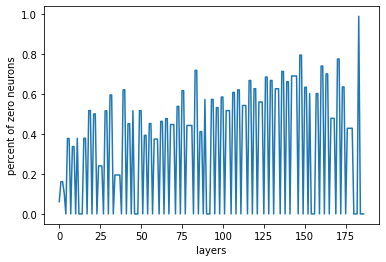

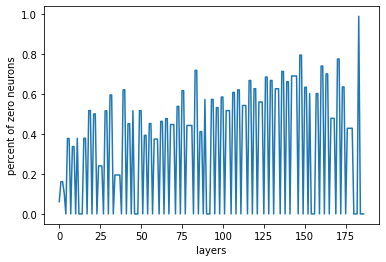

In [23]:
# get model
model1 = get_model(path_before_fine_tune)
plot_zeros_percent(model1, sample)


### after fine-tune

built classifier ...
trainable_params : 163



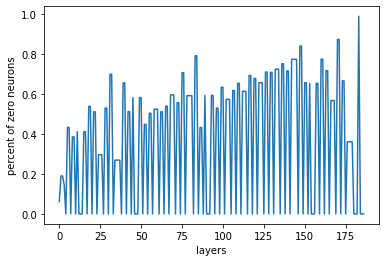

In [24]:
# get model
model2= get_model(path_after_fine_tune)
plot_zeros_percent(model2, sample)